# PURPOSE

    - Compare the morphology of real axons (from XNH-volumes) with synthetic axons (from the WMG).
    - Do the comparison based on:
        - Axon diameter variation
        - Undulation

d = 2 * sqrt(det(S) / r_axis);

where S is the shape matrix and r_axis is the "radius" of the ellipsoid along the axon axis.



In [1]:
%load_ext autoreload
%autoreload 2

# BASICS

In [2]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import norm, gamma
import math
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# sys.path.append('../../')
# import axon_generator_toolbox_wrapper.src.utils as agtw
sys.path.append('../')
from src import config_utils

/home/siwin/code/WhiteMatterGenerator/Configuration/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'sklearn'

# PATHS

In [3]:
path_CC = '/dtu-compute/siwin/projects/axon_generator_toolbox_wrapper/data/synchrotron/splenium/centerlines_sampled/'
path_CF = '/dtu-compute/siwin/projects/axon_generator_toolbox_wrapper/data/synchrotron/crossing/centerlines_sampled/'

#### dep
# path_CC_centrelines = '/dtu-compute/siwin/projects/susceptibility_in_silico/substrates/synchrotron-G6-z_aligned/centrelines/'
# path_CC_eccentricities = '/dtu-compute/siwin/projects/susceptibility_in_silico/substrates/synchrotron-G6-z_aligned/eccentricities/'
# path_CC_radii = '/dtu-compute/siwin/projects/susceptibility_in_silico/substrates/synchrotron-G3-z_aligned/xyzr'

In [4]:
path_project = '/dtu-compute/siwin/projects/axon_generator_toolbox_wrapper/'

# path_substrates = os.path.join(path_project, 'substrates', 'dep')
path_substrates = os.path.join(path_project, 'substrates')

# names_substrates = np.sort([n for n in os.listdir(path_substrates) if ('num_cylinders=221' in n) and ('.ipynb_checkpoints' not in n)])
# names_substrates = np.sort([n for n in os.listdir(path_substrates) if ('num_cylinders=250' in n) and ('.ipynb_checkpoints' not in n)])
names_substrates = np.sort([n for n in os.listdir(path_substrates) if ('num_cylinders=500' in n) and ('.ipynb_checkpoints' not in n)])
# names_substrates = np.sort([n for n in os.listdir(path_substrates) if ('num_cylinders=499' in n) and ('.ipynb_checkpoints' not in n)])
# names_substrates = np.sort([n for n in os.listdir(path_substrates) if ('num_cylinders=498' in n) and ('.ipynb_checkpoints' not in n)])

#### SELECT SUBSTRATES OF INTEREST
for idx, n in enumerate(names_substrates):
    print(idx, n)

# # names_substrates = names_substrates[19:20]
#### 'num_cylinders=500' and 'num_cylinders=250'
names_substrates = names_substrates[8:]
print(names_substrates)
# #### 'num_cylinders=499'
# names_substrates = names_substrates[:3]
# print(names_substrates)

0 cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=mixed-fiber0-frac=0.5-orientation=[0,0,1]-epsilon=0.0-contractSpeed=0.1-fiber2-frac=0.5-orientation=[0,1,0]-epsilon=0.0-contractSpeed=0.1
1 cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=mixed-fiber0-frac=0.5-orientation=[0,0,1]-epsilon=0.2-contractSpeed=0.1-fiber2-frac=0.5-orientation=[0,1,0]-epsilon=0.2-contractSpeed=0.1
2 cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=mixed-fiber0-frac=0.5-orientation=[0,0,1]-epsilon=0.4-contractSpeed=0.1-fiber2-frac=0.5-orientation=[0,1,0]-epsilon=0.4-contractSpeed=0.1
3 cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=mixed-fiber0-frac=0.5-orientation=[0,0,1]-epsilon=0.6-contractSpeed=0.1-fiber2-frac=0.5-orientation=[0,1,0]-epsilon=0.6-contractSpeed=0.1
4 cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=0.5-orientation=[0,0,1]-epsilon=0.0-contractSpeed=0.1-fiber2-frac=0.5-orie

# STYLES

In [5]:
color_CF = '#234520' # 'darkgreen'
color_CC = 'yellowgreen' #'yellowgreen'

def get_colors_without_cells():
#     return iter(['darkred', 'tab:red', 'tab:pink'])
    # return iter(['hotpink', 'crimson', 'darkred'])
    return iter(['#f2b8c4', '#d9415f', 'darkred'])

def get_colors_with_cells():
#     return iter(['navy', 'tab:blue', 'tab:cyan'])
    return iter(['darkturquoise', 'dodgerblue', 'navy'])

# colors_without_cells = iter(['#f2b8c4', '#d9415f', 'darkred'])
# colors_with_cells = iter(['darkturquoise', 'dodgerblue', 'navy'])


# EXTRACT MORPHOLOGICAL METRICS

### SRC

In [6]:
def get_sinousity_from_centreline(centreline):
    
    position_a = np.array(centreline[0])
    position_b = np.array(centreline[-1])

    length_straight = np.linalg.norm(position_b - position_a)

    length_along_traj = np.sum(np.linalg.norm(np.diff(centreline, axis=0), axis=1))
    
    sinousity = length_along_traj / length_straight
    # straightness = lengths_straight / lengths_along_traj #why not this?
    
    return sinousity

In [7]:
def get_max_deviation_from_centreline(centreline):
    
    position_a = np.array(centreline[0])
    position_b = np.array(centreline[-1])

    #distances = np.linalg.norm(np.cross(position_b-position_a, position_a-centreline))/np.linalg.norm(position_b-position_a)
    #distance_max = np.max(distances)

    distance_max = -np.inf
        
    for position_c in centreline:

        distance = np.linalg.norm(np.cross(position_b-position_a, position_a-position_c))/np.linalg.norm(position_b-position_a)

        if distance > distance_max:
            distance_max = distance
    
    return distance_max

In [8]:
def get_synchrotron_dict(path_content):
    
    synchrotron = {'axonCentrelines': [],
                   'axonSinousity': [],
                   'axonMaxDeviation': [],
                   'axonDiameters': [],
                   'axonDiameters_mean': [],
                   'axonDiameters_std': [],
                   'axonEccentricities': [],
                   'axonEccentricities_mean': [],
                   'axonEccentricities_std': [],
                  }

    for name_axon in np.sort(os.listdir(path_content)):

        path_axon = os.path.join(path_content, name_axon)

        quantified = np.loadtxt(path_axon, delimiter=',') # x [voxel-coords], y [voxel-coords], z [voxel-coords], tx, ty, tz, diameter [mm], eccentricity

        axonCentreline = quantified[:, :3] * 0.5 #
        axonSinousity = get_sinousity_from_centreline(axonCentreline)
        axonMaxDeviation = get_max_deviation_from_centreline(axonCentreline)
        axonDiameter = quantified[:, 6] * 1e3
        axonDiameter_mean = np.mean(axonDiameter)
        axonDiameter_std = np.std(axonDiameter)
        axonEccentricity = quantified[:, -1]
        axonEccentricity_mean = np.mean(axonEccentricity)
        axonEccentricity_std = np.std(axonEccentricity)

        synchrotron['axonCentrelines'].append(axonCentreline)
        synchrotron['axonSinousity'].append(axonSinousity)
        synchrotron['axonMaxDeviation'].append(axonMaxDeviation)
        synchrotron['axonDiameters'].append(axonDiameter)
        synchrotron['axonDiameters_mean'].append(axonDiameter_mean)
        synchrotron['axonDiameters_std'].append(axonDiameter_std)
        synchrotron['axonEccentricities'].append(axonEccentricity)
        synchrotron['axonEccentricities_mean'].append(axonEccentricity_mean)
        synchrotron['axonEccentricities_std'].append(axonEccentricity_std)
        
    return synchrotron

### XNH

In [9]:
synchrotron_CC = get_synchrotron_dict(path_CC)
synchrotron_CF = get_synchrotron_dict(path_CF)

### WMG

In [10]:
names_substrates

array(['cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.0-contractSpeed=0.1',
       'cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.2-contractSpeed=0.1',
       'cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.4-contractSpeed=0.1',
       'cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.6-contractSpeed=0.1',
       'cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.8-contractSpeed=0.1',
       'cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=1.0-contractSpeed=0.1'],
      dtype='<U207')

In [11]:
# for idx, n in enumerate(names_outputs):
#     print(idx, n)

In [12]:
dist_sampling = 0.5 # [um]

WMG_all = {}

for name_substrate in tqdm(names_substrates[0:]):
    
    print('name_substrate: ', name_substrate)
    
    alpha = float(name_substrate.split('alpha=')[-1].split('-')[0])
    beta = float(name_substrate.split('beta=')[-1].split('-')[0])
    
    WMG_all[name_substrate] = {'axonCentrelines': [],
                               'axonSinousity': [],
                               'axonMaxDeviation': [],
                               'axonDiameters': [],
                               'axonDiameters_mean': [],
                               'axonDiameters_std': [],
                               'myelinDiameters': [],
                               'myelinDiameters_mean': [],
                               'myelinDiameters_std': [],
                               'myelinEquivalentDiameters': [],
                               'myelinEquivalentDiameters_mean': [],
                               'myelinEquivalentDiameters_std': [],
                               'maxDiameter': [],
                               'nEllipsoids': [],
                               'axonEccentricities': [],
                               'axonEccentricities_mean': [],
                               'axonEccentricities_std': [],
                               'alpha_desired': alpha,
                               'beta_desired': beta,
                               'axonPCAs': [],
                              }
    
    path_substrate = os.path.join(path_substrates, name_substrate)
    
    names_outputs = np.sort([n for n in os.listdir(path_substrate) if ('output' in n)])
    
#     for name_output in tqdm(names_outputs[9:10]):
#     for name_output in tqdm(names_outputs[:1]):
    for name_output in tqdm(names_outputs):
        
        if ('stage=3_output' not in name_output) or ('rep_00' not in name_output):
            continue
        
        print('name_output: ', name_output)
        
        path_output = os.path.join(path_substrate, name_output)
        
        try:
            name_conf_output = np.sort([n for n in os.listdir(path_output) if ('config_output' in n)])[-1]
        except:
            print('OBS!! No output here...')
            continue
            
        path_conf_output = os.path.join(path_output, name_conf_output)
        
        with open(path_conf_output, 'r') as file:
            conf_output = json.load(file)
        
        for axon in conf_output['axons']:
            
            ##### PER AXON
            axonCentreline = []
            axonDiameter = []
            myelinDiameter = []
            myelinEquivalentDiameter = []
            axonEccentricities = []

            for ellipsoid in axon['ellipsoids']:
                
                if len(axonCentreline) > 0:
                    
                    pass
                    #print(math.dist(axonCentreline[-1], ellipsoid['position']))
                
                if (len(axonCentreline) == 0) or (math.dist(axonCentreline[-1], ellipsoid['position']) > dist_sampling):
                
                    axonCentreline.append(ellipsoid['position'])

                    axonDiameter.append(ellipsoid['axonDiameter']) 

                    myelinDiameter.append(ellipsoid['myelinDiameter']) # 2 * np.sqrt(S[0, 0] * S[1, 1]), or 2 * np.sqrt(np.linalg.det(S) / S[2, 2])

                    # equivalent diameter: the diameter of a circle which has an area equal to that of the ellipse
                    S = np.reshape(ellipsoid['shape'], (3, 3))
                    area_ellipse = np.pi * S[0, 0] * S[1, 1]
                    d_equivalent_circle = 2 * np.sqrt(area_ellipse / np.pi)
                    myelinEquivalentDiameter.append(d_equivalent_circle)

                    a, b = max(S[0, 0], S[1, 1]), min(S[0, 0], S[1, 1])
                    eccentricity = np.sqrt(1-b**2/a**2)
                    axonEccentricities.append(eccentricity)
                    
                else:
                    pass
                    #print('skipped...')

            # compute stuff
            axonSinousity = get_sinousity_from_centreline(axonCentreline)
            axonMaxDeviation = get_max_deviation_from_centreline(axonCentreline)
            axonDiameter_mean = np.mean(axonDiameter)
            axonDiameter_std = np.std(axonDiameter)
            myelinDiameter_mean = np.mean(myelinDiameter)
            myelinDiameter_std = np.std(myelinDiameter)
            myelinEquivalentDiameter_mean = np.mean(myelinEquivalentDiameter)
            myelinEquivalentDiameter_std = np.std(myelinEquivalentDiameter)
            nEllipsoids = len(axonCentreline)
            axonEccentricities_mean = np.mean(axonEccentricities)
            axonEccentricities_std = np.std(axonEccentricities)
            
            pca = PCA(n_components=3)
            pca.fit(axonCentreline)
            eigvals, eigvecs = pca.explained_variance_, pca.components_
            
            # add to dict
            WMG_all[name_substrate]['axonCentrelines'].append(axonCentreline)
            WMG_all[name_substrate]['axonSinousity'].append(axonSinousity)
            WMG_all[name_substrate]['axonMaxDeviation'].append(axonMaxDeviation)
            WMG_all[name_substrate]['axonDiameters'].append(axonDiameter)
            WMG_all[name_substrate]['axonDiameters_mean'].append(axonDiameter_mean)
            WMG_all[name_substrate]['axonDiameters_std'].append(axonDiameter_std)
            WMG_all[name_substrate]['myelinDiameters'].append(myelinDiameter)
            WMG_all[name_substrate]['myelinDiameters_mean'].append(myelinDiameter_mean)
            WMG_all[name_substrate]['myelinDiameters_std'].append(myelinDiameter_std)
            WMG_all[name_substrate]['myelinEquivalentDiameters'].append(myelinEquivalentDiameter)
            WMG_all[name_substrate]['myelinEquivalentDiameters_mean'].append(myelinEquivalentDiameter_mean)
            WMG_all[name_substrate]['myelinEquivalentDiameters_std'].append(myelinEquivalentDiameter_std)
            WMG_all[name_substrate]['maxDiameter'].append(axon['maxDiameter'])
            WMG_all[name_substrate]['nEllipsoids'].append(nEllipsoids)
            WMG_all[name_substrate]['axonEccentricities'].append(axonEccentricities)
            WMG_all[name_substrate]['axonEccentricities_mean'].append(axonEccentricities_mean)
            WMG_all[name_substrate]['axonEccentricities_std'].append(axonEccentricities_std)
            WMG_all[name_substrate]['axonPCAs'].append([eigvals, eigvecs])

  0%|          | 0/6 [00:00<?, ?it/s]

name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.0-contractSpeed=0.1


  0%|          | 0/40 [00:00<?, ?it/s]

name_output:  rep_00-stage=3_output
name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.2-contractSpeed=0.1


  0%|          | 0/48 [00:00<?, ?it/s]

name_output:  rep_00-stage=3_output
name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.4-contractSpeed=0.1


  0%|          | 0/48 [00:00<?, ?it/s]

name_output:  rep_00-stage=3_output
name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.6-contractSpeed=0.1


  0%|          | 0/48 [00:00<?, ?it/s]

name_output:  rep_00-stage=3_output
name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.8-contractSpeed=0.1


  0%|          | 0/48 [00:00<?, ?it/s]

name_output:  rep_00-stage=3_output
name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=1.0-contractSpeed=0.1


  0%|          | 0/48 [00:00<?, ?it/s]

name_output:  rep_00-stage=3_output


In [13]:
dist_sampling = 0.5 # [um]

WMG_all_cells = {}

for name_substrate in tqdm(names_substrates[0:]):
    
    print('name_substrate: ', name_substrate)
    
    alpha = float(name_substrate.split('alpha=')[-1].split('-')[0])
    beta = float(name_substrate.split('beta=')[-1].split('-')[0])
    
    WMG_all_cells[name_substrate] = {'axonCentrelines': [],
                               'axonSinousity': [],
                               'axonMaxDeviation': [],
                               'axonDiameters': [],
                               'axonDiameters_mean': [],
                               'axonDiameters_std': [],
                               'myelinDiameters': [],
                               'myelinDiameters_mean': [],
                               'myelinDiameters_std': [],
                               'myelinEquivalentDiameters': [],
                               'myelinEquivalentDiameters_mean': [],
                               'myelinEquivalentDiameters_std': [],
                               'maxDiameter': [],
                               'nEllipsoids': [],
                               'axonEccentricities': [],
                               'axonEccentricities_mean': [],
                               'axonEccentricities_std': [],
                               'alpha_desired': alpha,
                               'beta_desired': beta,
                               'axonPCAs': [],
                              }
    
    path_substrate = os.path.join(path_substrates, name_substrate)
    
    names_outputs = np.sort([n for n in os.listdir(path_substrate) if ('output' in n)])
    
#     for name_output in tqdm(names_outputs[8:9]):
#     for name_output in tqdm(names_outputs[:1]):
    for name_output in tqdm(names_outputs):
        
        if ('stage=3-with_cells' not in name_output) or ('rep_00' not in name_output):
            continue
        
        print('name_output: ', name_output)
        
        path_output = os.path.join(path_substrate, name_output)
        
        try:
            name_conf_output = np.sort([n for n in os.listdir(path_output) if ('config_output' in n)])[-1]
        except:
            print('OBS!! No output here...')
            continue
            
        path_conf_output = os.path.join(path_output, name_conf_output)
        
        with open(path_conf_output, 'r') as file:
            conf_output = json.load(file)
        
        for axon in tqdm(conf_output['axons']):
            
            ##### PER AXON
            axonCentreline = []
            axonDiameter = []
            myelinDiameter = []
            myelinEquivalentDiameter = []
            axonEccentricities = []
        
            for ellipsoid in axon['ellipsoids']:
                                
                if len(axonCentreline) > 0:
                    
                    pass
                    #print(math.dist(axonCentreline[-1], ellipsoid['position']))
                
                if (len(axonCentreline) == 0) or (math.dist(axonCentreline[-1], ellipsoid['position']) > dist_sampling):
                
                    axonCentreline.append(ellipsoid['position'])

                    axonDiameter.append(ellipsoid['axonDiameter']) 

                    myelinDiameter.append(ellipsoid['myelinDiameter']) # 2 * np.sqrt(S[0, 0] * S[1, 1]), or 2 * np.sqrt(np.linalg.det(S) / S[2, 2])

                    # equivalent diameter: the diameter of a circle which has an area equal to that of the ellipse
                    S = np.reshape(ellipsoid['shape'], (3, 3))
                    area_ellipse = np.pi * S[0, 0] * S[1, 1]
                    d_equivalent_circle = 2 * np.sqrt(area_ellipse / np.pi)
                    myelinEquivalentDiameter.append(d_equivalent_circle)

                    a, b = max(S[0, 0], S[1, 1]), min(S[0, 0], S[1, 1])
                    eccentricity = np.sqrt(1-b**2/a**2)
                    axonEccentricities.append(eccentricity)
                    
                else:
                    pass
                    #print('skipped...')

            # compute stuff
            axonSinousity = get_sinousity_from_centreline(axonCentreline)
            axonMaxDeviation = get_max_deviation_from_centreline(axonCentreline)
            axonDiameter_mean = np.mean(axonDiameter)
            axonDiameter_std = np.std(axonDiameter)
            myelinDiameter_mean = np.mean(myelinDiameter)
            myelinDiameter_std = np.std(myelinDiameter)
            myelinEquivalentDiameter_mean = np.mean(myelinEquivalentDiameter)
            myelinEquivalentDiameter_std = np.std(myelinEquivalentDiameter)
            nEllipsoids = len(axonCentreline)
            axonEccentricities_mean = np.mean(axonEccentricities)
            axonEccentricities_std = np.std(axonEccentricities)
            
            pca = PCA(n_components=3)
            pca.fit(axonCentreline)
            eigvals, eigvecs = pca.explained_variance_, pca.components_
            
            # add to dict
            WMG_all_cells[name_substrate]['axonCentrelines'].append(axonCentreline)
            WMG_all_cells[name_substrate]['axonSinousity'].append(axonSinousity)
            WMG_all_cells[name_substrate]['axonMaxDeviation'].append(axonMaxDeviation)
            WMG_all_cells[name_substrate]['axonDiameters'].append(axonDiameter)
            WMG_all_cells[name_substrate]['axonDiameters_mean'].append(axonDiameter_mean)
            WMG_all_cells[name_substrate]['axonDiameters_std'].append(axonDiameter_std)
            WMG_all_cells[name_substrate]['myelinDiameters'].append(myelinDiameter)
            WMG_all_cells[name_substrate]['myelinDiameters_mean'].append(myelinDiameter_mean)
            WMG_all_cells[name_substrate]['myelinDiameters_std'].append(myelinDiameter_std)
            WMG_all_cells[name_substrate]['myelinEquivalentDiameters'].append(myelinEquivalentDiameter)
            WMG_all_cells[name_substrate]['myelinEquivalentDiameters_mean'].append(myelinEquivalentDiameter_mean)
            WMG_all_cells[name_substrate]['myelinEquivalentDiameters_std'].append(myelinEquivalentDiameter_std)
            WMG_all_cells[name_substrate]['maxDiameter'].append(axon['maxDiameter'])
            WMG_all_cells[name_substrate]['nEllipsoids'].append(nEllipsoids)
            WMG_all_cells[name_substrate]['axonEccentricities'].append(axonEccentricities)
            WMG_all_cells[name_substrate]['axonEccentricities_mean'].append(axonEccentricities_mean)
            WMG_all_cells[name_substrate]['axonEccentricities_std'].append(axonEccentricities_std)
            WMG_all_cells[name_substrate]['axonPCAs'].append([eigvals, eigvecs])

  0%|          | 0/6 [00:00<?, ?it/s]

name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.0-contractSpeed=0.1


  0%|          | 0/40 [00:00<?, ?it/s]

name_output:  rep_00-stage=3-with_cells_output


  0%|          | 0/455 [00:00<?, ?it/s]

name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.2-contractSpeed=0.1


  0%|          | 0/48 [00:00<?, ?it/s]

name_output:  rep_00-stage=3-with_cells_output


  0%|          | 0/452 [00:00<?, ?it/s]

name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.4-contractSpeed=0.1


  0%|          | 0/48 [00:00<?, ?it/s]

name_output:  rep_00-stage=3-with_cells_output


  0%|          | 0/445 [00:00<?, ?it/s]

name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.6-contractSpeed=0.1


  0%|          | 0/48 [00:00<?, ?it/s]

name_output:  rep_00-stage=3-with_cells_output


  0%|          | 0/454 [00:00<?, ?it/s]

name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.8-contractSpeed=0.1


  0%|          | 0/48 [00:00<?, ?it/s]

name_output:  rep_00-stage=3-with_cells_output


  0%|          | 0/451 [00:00<?, ?it/s]

name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=1.0-contractSpeed=0.1


  0%|          | 0/48 [00:00<?, ?it/s]

name_output:  rep_00-stage=3-with_cells_output


  0%|          | 0/450 [00:00<?, ?it/s]

/tmp/ipykernel_2370/1950226881.py:10: RuntimeWarning: invalid value encountered in scalar divide
  sinousity = length_along_traj / length_straight
/tmp/ipykernel_2370/1710625980.py:13: RuntimeWarning: invalid value encountered in scalar divide
  distance = np.linalg.norm(np.cross(position_b-position_a, position_a-position_c))/np.linalg.norm(position_b-position_a)


ValueError: n_components=3 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

# ELLIPSOIDS PER AXON

In [14]:
# for name_substrate, substrate in WMG_all.items():
    
#     plt.figure(figsize=(7, 7))
    
#     print('name_substrate: ', name_substrate)
    
#     plt.scatter(substrate['maxDiameter'], substrate['nEllipsoids'], 
#                 color='tab:blue', alpha=0.5, label='WMG: example x')
        

#     plt.xlabel('maxDiameter [$\mu$m]')
#     plt.ylabel('ellipsoids per axon [#]')

In [15]:
# for name_substrate, substrate in WMG_all_cells.items():
    
#     plt.figure(figsize=(7, 7))
    
#     print('name_substrate: ', name_substrate)
    
#     plt.scatter(substrate['maxDiameter'], substrate['nEllipsoids'], 
#                 color='tab:blue', alpha=0.5, label='WMG: example x')
        

#     plt.xlabel('maxDiameter [$\mu$m]')
#     plt.ylabel('ellipsoids per axon [#]')

# DESIRED VS. OUTPUTED DIAMETER DISTRIBUTION FOR WMG

name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.0-contractSpeed=0.1
np.min(substrate['axonDiameters_mean']) 0.11270037927684336
name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.2-contractSpeed=0.1
np.min(substrate['axonDiameters_mean']) 0.2800187104778905
name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=1.0-contractSpeed=0.1
np.min(substrate['axonDiameters_mean']) 0.23401077676616727
name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.0-contractSpeed=0.1
np.min(substrate['axonDiameters_mean']) 0.13042263502973825


Text(0, 0.5, 'occurences [-]')

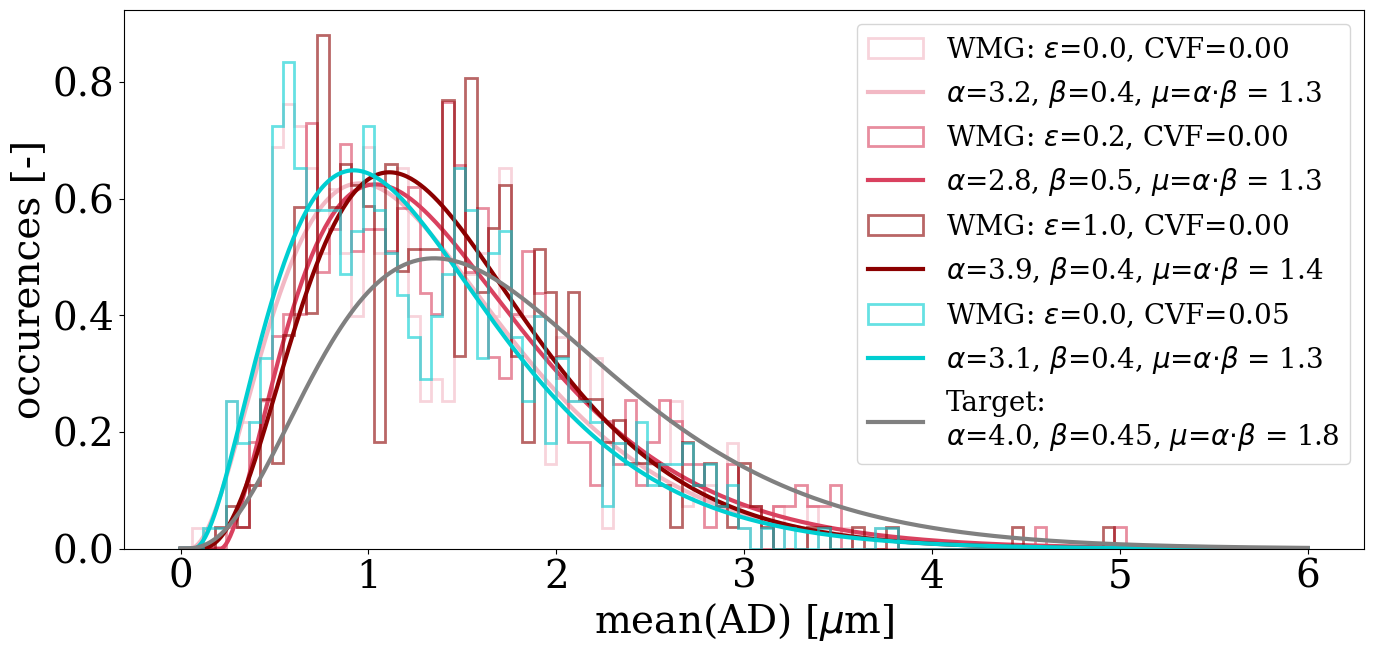

In [26]:
plt.figure(figsize=(16, 7))

#xmax = 12
xmax = 6
bins = np.linspace(0, xmax, 100)
xs_fit = np.linspace(np.min(bins), np.max(bins), 500)

# colors_without_cells = iter(['hotpink', 'crimson', 'darkred'])
colors_without_cells = get_colors_without_cells() #iter(['#f2b8c4', '#d9415f', 'darkred'])
colors_with_cells = get_colors_with_cells() #iter(['darkturquoise', 'dodgerblue', 'navy'])

for name_substrate, substrate in WMG_all.items():
    
    epsilon = name_substrate.split('epsilon=')[-1].split('-')[0]
    
    if epsilon not in ['0.0', '0.2', '1.0']:
        continue
    if any([k in name_substrate for k in ['fiber1', 'fiber2']]):
        continue
        
    print('name_substrate: ', name_substrate)
    
    color = next(colors_without_cells)
    
    label = 'WMG: $\epsilon$'+f'={epsilon}, CVF=0.00'
    
    print("np.min(substrate['axonDiameters_mean'])", np.min(substrate['axonDiameters_mean']))

    plt.hist(substrate['axonDiameters_mean'], bins=bins, histtype='step', 
             color=color, lw=2, density=True, alpha=0.6, label=label)
    
    fit_args = gamma.fit(substrate['axonDiameters_mean'])
    shape, loc, scale = fit_args
    label = r'$\alpha$=%.1f, $\beta$=%.1f, $\mu$=$\alpha$$\cdot$$\beta$ = %.1f' %(shape, scale, shape*scale)
    y_norm_fit = gamma.pdf(xs_fit, *fit_args)
    plt.plot(xs_fit, y_norm_fit, lw=3, color=color, label=label)
    
for name_substrate, substrate in WMG_all_cells.items():
    
    epsilon = name_substrate.split('epsilon=')[-1].split('-')[0]
    
    if epsilon not in ['0.0']:
        continue
    if any([k in name_substrate for k in ['fiber1', 'fiber2']]):
        continue
    
    print('name_substrate: ', name_substrate)
    
    color = next(colors_with_cells)
    
    label = 'WMG: $\epsilon$'+f'={epsilon}, CVF=0.05'
    
    print("np.min(substrate['axonDiameters_mean'])", np.min(substrate['axonDiameters_mean']))

    plt.hist(substrate['axonDiameters_mean'], bins=bins, histtype='step', 
             color=color, lw=2, density=True, alpha=0.6, label=label)
    
    fit_args = gamma.fit(substrate['axonDiameters_mean'])
    shape, loc, scale = fit_args
    label = r'$\alpha$=%.1f, $\beta$=%.1f, $\mu$=$\alpha$$\cdot$$\beta$ = %.1f' %(shape, scale, shape*scale)
    y_norm_fit = gamma.pdf(xs_fit, *fit_args)
    plt.plot(xs_fit, y_norm_fit, lw=3, color=color, label=label)
    
#### FIT WMG OUTPUT
alpha = float(name_substrate.split('alpha=')[-1].split('-')[0])
beta = float(name_substrate.split('beta=')[-1].split('-')[0])
    
x = np.linspace(0, np.max(xmax), 500)
y = stats.gamma.pdf(x, a=alpha, scale=2*beta)

plt.plot(x, y, color='gray', lw=3, label='Target:\n'+rf'$\alpha$={alpha}, $\beta$={2*beta}, $\mu$=$\alpha$$\cdot$$\beta$ = {alpha*2*beta}')

#### CC
# plt.hist(synchrotron_CC['axonDiameters_mean'], bins=bins, histtype='step', 
#              color='tab:orange', lw=2, density=True, alpha=0.6, label=f'XNH: CC')

#### LAYOUT
handles, labels = plt.gca().get_legend_handles_labels()
# order = [1, 2, 0]
# order = [2, 3, 0, 4, 1]
# handles, labels = [handles[idx] for idx in order], [labels[idx] for idx in order]
plt.legend(handles, labels, fontsize=20)

plt.xlabel('mean(AD) [$\mu$m]')
plt.ylabel('occurences [-]')

In [ ]:
# substrate['axonDiameters_mean']

# std(AD) vs. mean(AD)

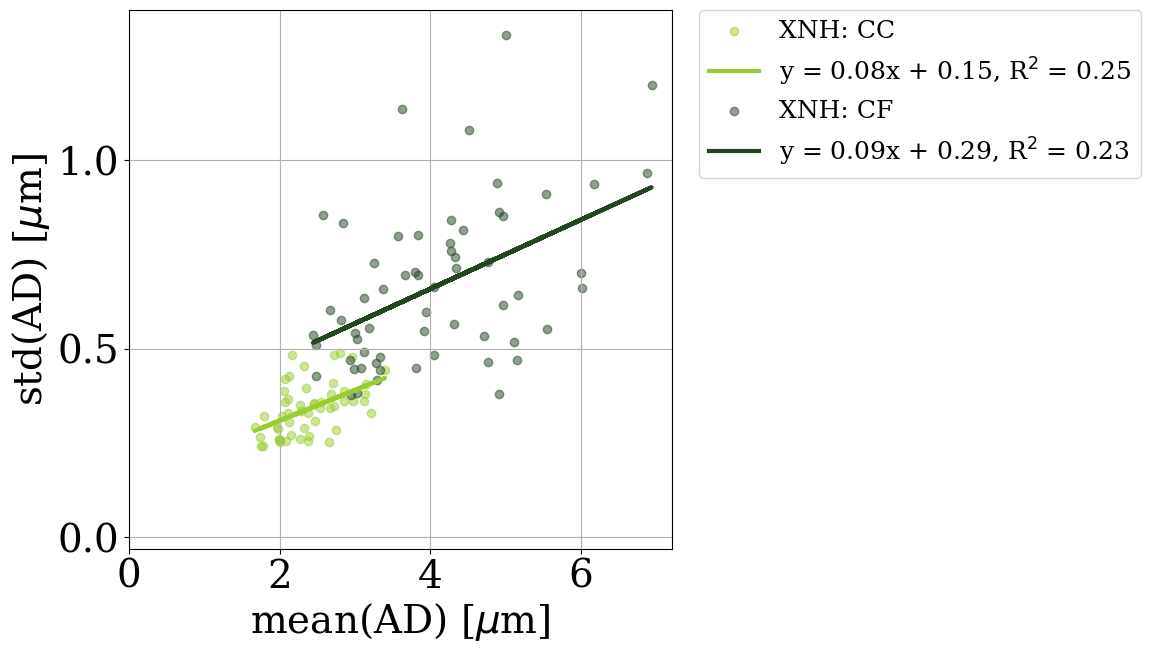

In [19]:
plt.figure(figsize=(7, 7))
bins = np.linspace(-2.0, 2.0, 50)
# cmap = plt.cm.get_cmap('gnuplot2')

# colors_without_cells = iter(['hotpink', 'crimson', 'darkred'])
colors_without_cells = get_colors_without_cells() #iter(['#f2b8c4', '#d9415f', 'darkred'])
colors_with_cells = get_colors_with_cells() #iter(['darkturquoise', 'dodgerblue', 'navy'])

alpha = 0.5

def func_line(x, a, b):
    return a*x + b

#### ADD WMG SAMPLES

# for name_substrate, substrate in WMG_all.items():
    
#     epsilon = name_substrate.split('epsilon=')[-1].split('-')[0]
    
#     if epsilon not in ['0.0', '0.2', '1.0']:
#         continue
#     if any([k in name_substrate for k in ['fiber1', 'fiber2']]):
#         continue
        
#     print('name_substrate: ', name_substrate)
    
#     color = next(colors_without_cells)
    
#     label = 'WMG: $\epsilon$'+f'={epsilon}, CVF=0.00'
#     plt.scatter(substrate['axonDiameters_mean'], substrate['axonDiameters_std'], 
#                 color=color, alpha=alpha, label=label)
    
#     # fit
#     popt, pcov = curve_fit(func_line, substrate['axonDiameters_mean'], substrate['axonDiameters_std'])
#     y_pred = func_line(np.array(substrate['axonDiameters_mean']), *popt)
    
#     # r_squared
#     r_squared = r2_score(substrate['axonDiameters_std'], y_pred)
    
#     #ss_tot = np.sum((substrate['axonDiameters_std']-np.mean(substrate['axonDiameters_std']))**2)
#     #residuals = substrate['axonDiameters_std'] - y_pred
#     #ss_res = np.sum(residuals**2)
#     #r_squared = 1 - (ss_res / ss_tot)
    
#     # plot
#     label = 'y = %.2fx + %.2f, R$^2$ = %.2f' %(popt[0], popt[1], r_squared)
#     plt.plot(substrate['axonDiameters_mean'], y_pred, color=color, lw=3,
#              label=label)
    

# for name_substrate, substrate in WMG_all_cells.items():
    
#     epsilon = name_substrate.split('epsilon=')[-1].split('-')[0]
    
#     if epsilon not in ['0.0']:
#         continue
#     if any([k in name_substrate for k in ['fiber1', 'fiber2']]):
#         continue
    
#     print('name_substrate: ', name_substrate)
    
#     color = next(colors_with_cells)
    
#     label = 'WMG: $\epsilon$'+f'={epsilon}, CVF=0.05'
#     plt.scatter(substrate['axonDiameters_mean'], substrate['axonDiameters_std'], 
#                 color=color, alpha=alpha, label=label)
    
#     # fit
#     popt, pcov = curve_fit(func_line, substrate['axonDiameters_mean'], substrate['axonDiameters_std'])
#     y_pred = func_line(np.array(substrate['axonDiameters_mean']), *popt)
    
#     # r_squared
#     r_squared = r2_score(substrate['axonDiameters_std'], y_pred)
    
#     #ss_tot = np.sum((substrate['axonDiameters_std']-np.mean(substrate['axonDiameters_std']))**2)
#     #residuals = substrate['axonDiameters_std'] - y_pred
#     #ss_res = np.sum(residuals**2)
#     #r_squared = 1 - (ss_res / ss_tot)
    
#     # plot
#     label = 'y = %.2fx + %.2f, R$^2$ = %.2f' %(popt[0], popt[1], r_squared)
#     plt.plot(substrate['axonDiameters_mean'], y_pred, color=color, lw=3,
#              label=label)
    
    
    
#### ADD SYNCHROTRON SAMPLES

#### CC
plt.scatter(synchrotron_CC['axonDiameters_mean'], synchrotron_CC['axonDiameters_std'], 
            color=color_CC, alpha=alpha, label='XNH: CC')
    
# fit
popt, pcov = curve_fit(func_line, synchrotron_CC['axonDiameters_mean'], synchrotron_CC['axonDiameters_std'])
y_pred = func_line(np.array(synchrotron_CC['axonDiameters_mean']), *popt)

# r_squared
r_squared = r2_score(synchrotron_CC['axonDiameters_std'], y_pred)

# plot
label = 'y = %.2fx + %.2f, R$^2$ = %.2f' %(popt[0], popt[1], r_squared)
plt.plot(synchrotron_CC['axonDiameters_mean'], y_pred, color=color_CC, lw=3,
         label=label)

#### CF
plt.scatter(synchrotron_CF['axonDiameters_mean'], synchrotron_CF['axonDiameters_std'], 
            color=color_CF, alpha=alpha, label='XNH: CF')
    
# fit
popt, pcov = curve_fit(func_line, synchrotron_CF['axonDiameters_mean'], synchrotron_CF['axonDiameters_std'])
y_pred = func_line(np.array(synchrotron_CF['axonDiameters_mean']), *popt)

# r_squared
r_squared = r2_score(synchrotron_CF['axonDiameters_std'], y_pred)

# plot
label = 'y = %.2fx + %.2f, R$^2$ = %.2f' %(popt[0], popt[1], r_squared)
plt.plot(synchrotron_CF['axonDiameters_mean'], y_pred, color=color_CF, lw=3,
         label=label)


    
#### LAYOUT
plt.xlabel('mean(AD) [$\mu$m]') # longitudinal axon diameter (LAD)
plt.ylabel('std(AD) [$\mu$m]')

#legend
handles, labels = plt.gca().get_legend_handles_labels()
# order = [4, 0, 5, 1, 6, 2, 7, 3]
# handles, labels = [handles[idx] for idx in order], [labels[idx] for idx in order]
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=18)

# plt.xlim(-0.3, 12.3)
# plt.ylim(-0.1, 1.6)

plt.xlim(0.0, 7.2)
plt.ylim(-0.03, 1.4)

plt.yticks([0.0, 0.5, 1.0])

plt.grid(True)

# ECCENTRICITY

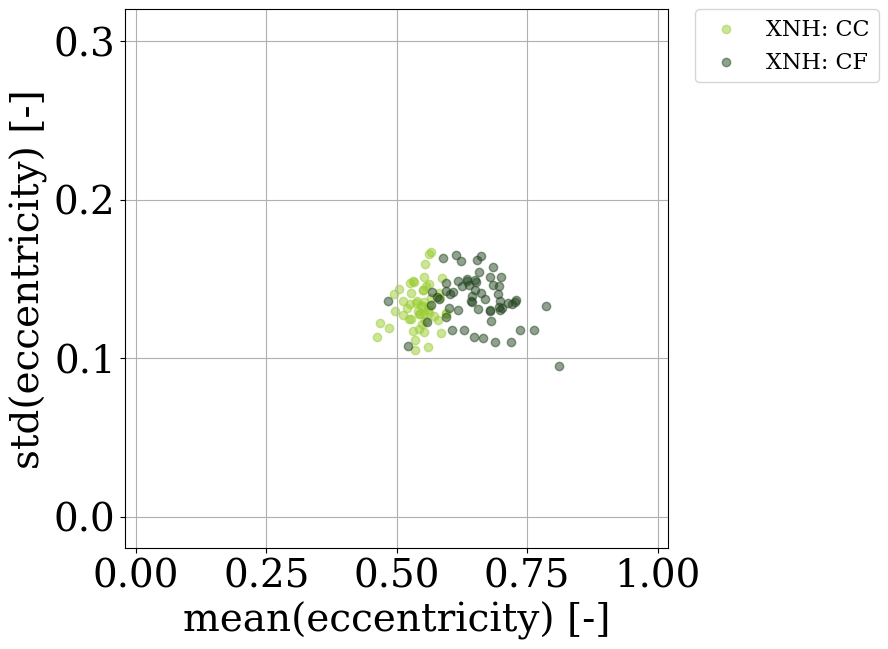

In [22]:
plt.figure(figsize=(7, 7))
# bins = np.linspace(-2.0, 2.0, 50)
# cmap = plt.cm.get_cmap('gnuplot2')

alpha = 0.5

# colors_without_cells = iter(['hotpink', 'crimson', 'darkred'])
# colors_with_cells = iter(['darkturquoise', 'dodgerblue', 'navy'])
colors_without_cells = get_colors_without_cells() #iter(['#f2b8c4', '#d9415f', 'darkred'])
colors_with_cells = get_colors_with_cells() #iter(['darkturquoise', 'dodgerblue', 'navy'])

#### ADD WMG SAMPLES

# for name_substrate, substrate in WMG_all_cells.items():
    
#     epsilon = name_substrate.split('epsilon=')[-1].split('-')[0]
    
#     if epsilon not in ['0.0']:
#         continue
#     if any([k in name_substrate for k in ['fiber1', 'fiber2']]):
#         continue
    
#     print('name_substrate: ', name_substrate)
    
#     color = next(colors_with_cells)
    
#     label = 'WMG: $\epsilon$'+f'={epsilon}, CVF=0.05'
    
#     plt.scatter(substrate['axonEccentricities_mean'], substrate['axonEccentricities_std'], 
#                 color=color, alpha=alpha, label=label)

# for name_substrate, substrate in WMG_all.items():
    
#     epsilon = name_substrate.split('epsilon=')[-1].split('-')[0]
    
#     if epsilon not in ['0.0', '0.2', '1.0']:
#         continue
#     if any([k in name_substrate for k in ['fiber1', 'fiber2']]):
#         continue
    
#     print('name_substrate: ', name_substrate)
    
#     color = next(colors_without_cells)
    
#     label = 'WMG: $\epsilon$'+f'={epsilon}, CVF=0.00'
    
#     plt.scatter(substrate['axonEccentricities_mean'], substrate['axonEccentricities_std'], 
#                 color=color, alpha=alpha, 
#                 #label='WMG: example x')    
#                 label=label)    
    
    
#### ADD SYNCHROTRON SAMPLES

#### CC
plt.scatter(synchrotron_CC['axonEccentricities_mean'], synchrotron_CC['axonEccentricities_std'], 
            color=color_CC, alpha=alpha, label='XNH: CC')

#### CF
plt.scatter(synchrotron_CF['axonEccentricities_mean'], synchrotron_CF['axonEccentricities_std'], 
            color=color_CF, alpha=alpha, label='XNH: CF')



#### LAYOUT
# plt.xlabel('mean(eccentricity) [-]') # longitudinal axon diameter (LAD)
# plt.ylabel('Occurences [-]')
plt.xlabel('mean(eccentricity) [-]') # longitudinal axon diameter (LAD)
plt.ylabel('std(eccentricity) [-]')

plt.xlim(-0.02, 1.02)
plt.xticks([0.0, 0.25, 0.50, 0.75, 1.0])
plt.ylim(-0.02, 0.32)

#legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=16)

plt.grid(True)

In [ ]:
# # e = 0
# a = 1
# b = 1

# # e = 0.25
# a = 1.033
# b = 1

# # e = 0.5
# a = 1.155
# b = 1

# e = 0.75
a = 1.52
b = 1

np.sqrt(1 - b**2/a**2 )

# TORTUOSITY

### SINOUSITY

In [ ]:
# plt.figure(figsize=(12, 7))
# bins = np.linspace(1.0, 1.45, 100)
# cmap = plt.cm.get_cmap('gnuplot2')

# for name_substrate, substrate in WMG_all.items():
    
#     print('name_substrate: ', name_substrate)
    
#     plt.hist(substrate['axonSinousity'], bins=bins, color='tab:blue', alpha=0.5, label='WMG: example x')
    
# for name_substrate, substrate in WMG_all_cells.items():
    
#     print('name_substrate: ', name_substrate)
    
#     plt.hist(substrate['axonSinousity'], bins=bins, color='tab:green', alpha=0.5, label='WMG: example x w. cells')

    
# #### ADD SYNCHROTRON SAMPLES

# #### CC
# plt.hist(synchrotron_CC['axonSinousity'], bins=bins, color='tab:orange', alpha=0.5, label='XNH: CC')

# #### CF
# plt.hist(synchrotron_CF['axonSinousity'], bins=bins, color='tab:red', alpha=0.5, label='XNH: CF')


    
# #### LAYOUT
# plt.xlabel('sinousity [-]')
# plt.ylabel('occurences [-]')

# #legend
# handles, labels = plt.gca().get_legend_handles_labels()
# # order = [3, 0, 4, 1, 5, 2]
# # handles, legends = [handles[idx] for idx in order], [labels[idx] for idx in order]
# # plt.legend(handles, legends, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=16)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=16)

# plt.grid(True)

### MAX DEVIATION FROM STRAIGHT LINE

In [ ]:
# plt.figure(figsize=(12, 7))
# bins = np.linspace(0, 125, 100)
# cmap = plt.cm.get_cmap('gnuplot2')

# for name_substrate, substrate in WMG_all.items():
    
#     print('name_substrate: ', name_substrate)
    
#     plt.hist(substrate['axonMaxDeviation'], bins=bins, color='tab:blue', alpha=0.5, 
#              label='WMG: example x')
    
# for name_substrate, substrate in WMG_all_cells.items():
    
#     print('name_substrate: ', name_substrate)
    
#     plt.hist(substrate['axonMaxDeviation'], bins=bins, color='tab:green', alpha=0.5, 
#              label='WMG: example x w. cells')

    
    
# #### ADD SYNCHROTRON SAMPLES

# #### CC
# plt.hist(synchrotron_CC['axonMaxDeviation'], bins=bins, color='tab:orange', alpha=0.5, label='XNH: CC')

# #### CF
# plt.hist(synchrotron_CF['axonMaxDeviation'], bins=bins, color='tab:red', alpha=0.5, label='XNH: CF')


    
# #### LAYOUT
# plt.xlabel('max deviation from straight line [-]')
# plt.ylabel('occurences [-]')

# #legend
# handles, labels = plt.gca().get_legend_handles_labels()
# # order = [3, 0, 4, 1, 5, 2]
# # handles, legends = [handles[idx] for idx in order], [labels[idx] for idx in order]
# # plt.legend(handles, legends, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=16)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=16)

# plt.grid(True)

### SOME SCATTER PLOTS

name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.0-contractSpeed=0.1
name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.0-contractSpeed=0.1
name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=0.2-contractSpeed=0.1
name_substrate:  cylinders-alpha=4.0-beta=0.225-icvf=0.8-num_cylinders=500-mode_fiber=sheets-fiber0-frac=1.0-orientation=[0,0,1]-epsilon=1.0-contractSpeed=0.1


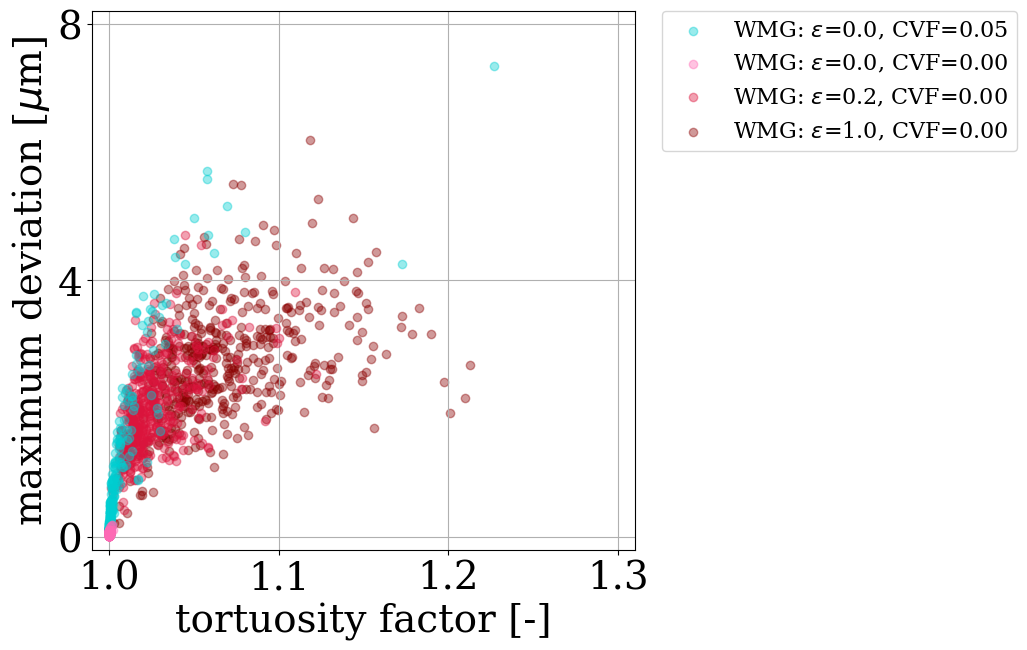

In [25]:
plt.figure(figsize=(7, 7))

alpha = 0.4

zorder = 0 

#### WMG

colors_without_cells = iter(['hotpink', 'crimson', 'darkred'])
colors_with_cells = iter(['darkturquoise', 'dodgerblue', 'navy'])
    
for name_substrate, substrate in WMG_all_cells.items():
    
    epsilon = name_substrate.split('epsilon=')[-1].split('-')[0]
    
    if epsilon not in ['0.0']:
        continue
    if any([k in name_substrate for k in ['fiber1', 'fiber2']]):
        continue
        
    if epsilon in ['0.0']:
        zorder = 3
    
    print('name_substrate: ', name_substrate)
    
    color = next(colors_with_cells)
    
    label = 'WMG: $\epsilon$'+f'={epsilon}, CVF=0.05'
    
    plt.scatter(substrate['axonSinousity'], substrate['axonMaxDeviation'],
                color=color, alpha=alpha, 
                label=label, zorder=zorder)

for name_substrate, substrate in WMG_all.items():
    
    epsilon = name_substrate.split('epsilon=')[-1].split('-')[0]
    
    if epsilon not in ['0.0', '0.2', '1.0']:
        continue
    if any([k in name_substrate for k in ['fiber1', 'fiber2']]):
        continue
    
    if epsilon in ['0.0']:
        zorder = 4
    elif epsilon in ['0.2']:
        zorder = 2
    elif epsilon in ['1.0']:
        zorder = 1
        
    print('name_substrate: ', name_substrate)
    
    color = next(colors_without_cells)
    
    label = 'WMG: $\epsilon$'+f'={epsilon}, CVF=0.00'
    
    plt.scatter(substrate['axonSinousity'], substrate['axonMaxDeviation'],
                color=color, alpha=alpha, label=label, zorder=zorder)

plt.xlim(0.99, 1.31)
#plt.ylim(-1, 13.5)
plt.ylim(-0.2, 8.2)
#plt.yticks([0.0, 4, 8, 12])
plt.yticks([0.0, 4, 8])

    
# #### XNH    
# plt.scatter(synchrotron_CC['axonSinousity'], synchrotron_CC['axonMaxDeviation'], 
#             color=color_CC, alpha=alpha, label='XNH: CC')

# plt.scatter(synchrotron_CF['axonSinousity'], synchrotron_CF['axonMaxDeviation'], 
#             color=color_CF, alpha=alpha, label='XNH: CF')

# plt.xlim(0.98, 1.48)
# plt.xticks([1.0, 1.1, 1.2, 1.3, 1.4])
# plt.ylim(-1, 65)
# plt.yticks([0.0, 4, 8, 20, 40, 60])



####

plt.grid(True)
plt.xlabel('tortuosity factor [-]')
plt.ylabel('maximum deviation [$\mu$m]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=16)

### VISUALISATION

In [ ]:
def get_rotation_matrix(i_v, unit=[0.0, 0.0, 1.0]):
    # From http://www.j3d.org/matrix_faq/matrfaq_latest.html#Q38
    
    # Normalize vector length
    i_v = i_v / np.linalg.norm(i_v)

    # Get axis
    uvw = np.cross(unit, i_v)

    # compute trig values - no need to go through arccos and back
    rcos = np.dot(i_v, unit)
    rsin = np.linalg.norm(uvw)

    #normalize and unpack axis
    if not np.isclose(rsin, 0):
        uvw /= rsin
    u, v, w = uvw

    # Compute rotation matrix - re-expressed to show structure
    return (
        rcos * np.eye(3) +
        rsin * np.array([
            [ 0, -w,  v],
            [ w,  0, -u],
            [-v,  u,  0]
        ]) +
        (1.0 - rcos) * uvw[:,None] * uvw[None,:]
    )

In [ ]:
import matplotlib
# from pygel3d import hmesh, gl_display as gl
# from pygel3d import jupyter_display as jd

In [ ]:
plt.figure(figsize=(8, 7))

bins_tortuosity = np.arange(0.99, 1.3, 0.05)
bins_distances_max = np.arange(-0.01, 11.01, 0.5)

for name_substrate, substrate in WMG_all_cells.items():
# for name_substrate, substrate in WMG_all.items():
    
    epsilon = name_substrate.split('epsilon=')[-1].split('-')[0]
    
    if epsilon not in ['0.0']:
#     if epsilon not in ['0.2']:
#     if epsilon not in ['1.0']:
        continue
    if any([k in name_substrate for k in ['fiber1', 'fiber2']]):
        continue
    
    print('name_substrate: ', name_substrate)

    #plt.hist2d(substrate['axonSinousity'], substrate['axonMaxDeviation'], bins=[bins_tortuosity, bins_distances_max])

    #### add rectangles
    limits = [
#         dep
#               [0.99, 1.001, -0.01, 0.005], #epsilon=0.0
#               [0.99, 1.03, 5.9, 6.1], #epsilon=0.2
#               [1.15, 2.00, 5.9, 6.9], #epsilon=1.0
#               [1.25, 2.00, 12.0, 13.0], #epsilon=1.0
#         new
#               [0.99, 1.001, -0.01, 0.005], #epsilon=0.0
#               [0.99, 1.03, 5.9, 6.1], #epsilon=0.2
#               [1.15, 2.00, 5.9, 6.9], #epsilon=1.0
              [1.20, 2.00, 7.0, 8.0], #epsilon=1.0, w. cells

             ]

    for limit in limits:

        print('limit', limit)

        min_s, max_s, min_d, max_d = limit
        mask = (np.array(substrate['axonSinousity']) > min_s) * (np.array(substrate['axonSinousity']) < max_s) * (np.array(substrate['axonMaxDeviation']) > min_d) * (np.array(substrate['axonMaxDeviation']) < max_d)
        idxs_oi = np.argwhere(mask == True)
        print('len(idxs_oi)', len(idxs_oi))

#         rect = matplotlib.patches.Rectangle((min_s, min_d), (max_s-min_s), (max_d-min_d), 
#                                             lw=3, alpha=0.5, edgecolor='red', facecolor='None')
#         plt.gca().add_patch(rect)

        data = []

        #for idx in idxs_oi[:8]:
        for idx in idxs_oi[:1]:
#         for idx in idxs_oi[1:2]:
            
            centreline = np.array(substrate['axonCentrelines'][idx[0]])
            centreline -= centreline[-1, :]

            rotation_matrix = get_rotation_matrix(centreline[0, :], unit=[1, 0, 0])
            positions = np.dot(centreline, rotation_matrix)

            plot_trajectory = go.Scatter3d(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2],
                                           mode='lines', line=dict(width=20, color='grey'))
                                           #mode='markers', marker=dict(size=16, color='grey'))
            
            plot_straight = go.Scatter3d(x=np.linspace(positions[0, 0], positions[-1, 0], 1200), 
                                         y=np.linspace(positions[0, 1], positions[-1, 1], 1200), 
                                         z=np.linspace(positions[0, 2], positions[-1, 2], 1200),
                                         #mode='lines', line=dict(width=16, color='#1f77b4'))
                                         mode='markers', marker=dict(size=2, color='#1f77b4'))

            data += [plot_straight, plot_trajectory]

        layout = go.Layout(scene=dict(aspectmode='data',
                                      xaxis_title='', yaxis_title='', zaxis_title='',
                                     xaxis = dict(nticks=10, range=[0,100],
                                                  backgroundcolor="white",
                                                  gridcolor="white",
                                                  showbackground=True,
                                                  zerolinecolor="white",
                                                  showticklabels=False),
                                     yaxis = dict(nticks=4, range=[-20,20],
                                                  backgroundcolor="white",
                                                  gridcolor="white",
                                                  showbackground=True,
                                                  zerolinecolor="white",
                                                  showticklabels=False),
                                     zaxis = dict(nticks=4, range=[-20,20],
                                                  backgroundcolor="white",
                                                  gridcolor="white",
                                                  showbackground=True,
                                                  zerolinecolor="white",
                                                  showticklabels=False),
                                      ), 
                           width=1000,height=400)
        
        camera = dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=0, y=1.25, z=1.25)
        )
        
        fig = go.Figure(data=data, layout=layout)
        fig.update_layout(showlegend=False)
        fig.update_layout(scene_camera=camera)
        fig.show()

#     ####
#     cbar = plt.colorbar()
#     cbar.set_label('occurences [#]')
#     plt.xlabel('straightness [-]')
#     plt.ylabel('maximum deviation [$\mu$m]')

#     plt.show()

# DISPERSION

In [ ]:
# for name_substrate, substrate in WMG_all.items():
    
#     print('name_substrate: ', name_substrate)
    
#     plots_eig_vecs = []
    
#     for pca, centreline in zip(substrate['axonPCAs'], substrate['axonCentrelines']):

#         eigvals, eigvecs = pca
#         centreline = np.array(centreline)
        
#         #### PLOT LINES        
#         vec1 = eigvecs[0]

#         plot_eig_vecs = go.Scatter3d(x=[vec1[0], -vec1[0]], 
#                                      y=[vec1[1], -vec1[1]], 
#                                      z=[vec1[2], -vec1[2]], 
#                                      mode='lines', 
#                                      line=dict(color='blue', width=8)
#                                      )

#         plots_eig_vecs.append(plot_eig_vecs)
            
#     data = plots_eig_vecs

#     layout = go.Layout(scene=dict(aspectmode='data',), width=850,height=800)
#     fig = go.Figure(data=data, layout=layout)
#     fig.show()

In [ ]:
def get_unit_sphere_wireframe_plot():
    
    """
    https://community.plotly.com/t/adding-wireframe-around-a-sphere/37661/2
    """
    
    from numpy import pi, cos, sin

    theta = np.linspace(0, 2*pi, 120)
    print(len(theta))
    phi = np.linspace(0, pi, 60)
    u , v = np.meshgrid(theta, phi)
    xs = cos(u)*sin(v)
    ys = sin(u)*sin(v)
    zs = cos(v)

    x = []
    y = []
    z = []
    #for t in [theta[10*k] for k in range(12)]:  # meridians:
    for t in [theta[5*k] for k in range(24)]:  # meridians:
        x.extend(list(cos(t)*sin(phi))+[None])# None is inserted to mark the end of a meridian line
        y.extend(list(sin(t)*sin(phi))+[None]) 
        z.extend(list(cos(phi))+[None])

    #for s in [phi[6*k] for k in range(10)]:  # parallels
    for s in [phi[3*k] for k in range(20)]:  # parallels
        x.extend(list(cos(theta)*sin(s))+[None]) # None is inserted to mark the end of a parallel line 
        y.extend(list(sin(theta)*sin(s))+[None]) 
        z.extend([cos(s)]*120+[None])

    plot_surface = go.Surface(x=xs, y=ys, z=zs, 
                    colorscale=[[0, '#ffffff' ], [1, '#ffffff']], 
                    showscale=False, opacity=1.0)  # or opacity=1
    plot_wireframe = go.Scatter3d(x=x, y=y, z=z, mode='lines', line_width=3, line_color='rgb(10,10,10)')
    
    return plot_surface, plot_wireframe

In [ ]:
WMG_all.keys()

In [ ]:
for name_substrate, substrate in WMG_all.items():
    
    if epsilon not in ['0.2']:
#     if epsilon not in ['1.0']:
        continue
    if any([k in name_substrate for k in ['fiber1', 'fiber2']]):
        continue
    
    print('name_substrate: ', name_substrate)
    
    scaler = 1.02
    
    data = []
    
    for pca, centreline in zip(substrate['axonPCAs'], substrate['axonCentrelines']):

        eigvals, eigvecs = pca
        centreline = np.array(centreline)
        
        #### PLOT LINES        
        vec1 = eigvecs[0]

        plot_eig_vecs = go.Scatter3d(x=[vec1[0]*scaler, -vec1[0]*scaler], 
                                     y=[vec1[1]*scaler, -vec1[1]*scaler], 
                                     z=[vec1[2]*scaler, -vec1[2]*scaler], 
                                     mode='markers', 
                                     opacity=0.7,
                                     line=dict(color='#1f77b4', width=8),
                                     marker=dict(size=6)
                                     )

        data.append(plot_eig_vecs)
            
    #### plot unit sphere
    plot_surface, plot_wireframe = get_unit_sphere_wireframe_plot()
    
    data.append(plot_surface)
    data.append(plot_wireframe)

    layout = go.Layout(scene=dict(aspectmode='data',), width=850, height=800,
                       showlegend=False)
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(
        scene = dict(
            xaxis = dict(visible=False),
            yaxis = dict(visible=False),
            zaxis =dict(visible=False)
            )
    )
    fig.update_layout(scene_camera = dict(up=dict(x=0, y=0, z=1),
                                          center=dict(x=0, y=0, z=0),
                                          #eye=dict(x=0.0, y=0.0, z=1.95)))
                                          eye=dict(x=0.0, y=1.15, z=1.95)))
    
#     fig.write_image(f'{name_substrate}-dispersion.png')#, width=400, height=400, scale=2)
    fig.show()
    
#     break

In [ ]:
plt.figure(figsize=(7, 7))

for name_substrate, substrate in WMG_all.items():
    
    print('name_substrate: ', name_substrate)
    
    plt.scatter(substrate['axonSinousity'], substrate['axonDiameters_mean'],
                color='tab:blue', alpha=0.5, label='WMG: example x')
    
plt.scatter(synchrotron_CC['axonSinousity'], synchrotron_CC['axonDiameters_mean'], 
            color='tab:orange', alpha=0.5, label='XNH: CC')

plt.scatter(synchrotron_CF['axonSinousity'], synchrotron_CF['axonDiameters_mean'], 
            color='tab:red', alpha=0.5, label='XNH: CF')


plt.xlabel('sinuosity [-]')
plt.ylabel('mean(AD) [$\mu$m]')
plt.legend()

In [ ]:
plt.figure(figsize=(7, 7))

for name_substrate, substrate in WMG_all.items():
    
    print('name_substrate: ', name_substrate)
    
    plt.scatter(substrate['axonMaxDeviation'], substrate['axonDiameters_mean'],
                color='tab:blue', alpha=0.5, label='WMG: example x')
    
plt.scatter(synchrotron_CC['axonMaxDeviation'], synchrotron_CC['axonDiameters_mean'], 
            color='tab:orange', alpha=0.5, label='XNH: CC')

plt.scatter(synchrotron_CF['axonMaxDeviation'], synchrotron_CF['axonDiameters_mean'], 
            color='tab:red', alpha=0.5, label='XNH: CF')


plt.xlabel('maximum deviation [-]')
plt.ylabel('mean(AD) [$\mu$m]')
plt.legend()

# DISPERSION

In [ ]:
for name_substrate, substrate in WMG_all.items():
    
    print('name_substrate: ', name_substrate)
    
    plots_eig_vecs = []
    
    for pca, centreline in zip(substrate['axonPCAs'], substrate['axonCentrelines']):

        eigvals, eigvecs = pca
        centreline = np.array(centreline)
        
        #### PLOT LINES        
        vec1 = eigvecs[0]

        plot_eig_vecs = go.Scatter3d(x=[vec1[0], -vec1[0]], 
                                     y=[vec1[1], -vec1[1]], 
                                     z=[vec1[2], -vec1[2]], 
                                     mode='lines', 
                                     line=dict(color='blue', width=8)
                                     )

        plots_eig_vecs.append(plot_eig_vecs)
            
    data = plots_eig_vecs

    layout = go.Layout(scene=dict(aspectmode='data',), width=850,height=800)
    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [ ]:
def get_unit_sphere_wireframe_plot():
    
    """
    https://community.plotly.com/t/adding-wireframe-around-a-sphere/37661/2
    """
    
    from numpy import pi, cos, sin

    theta = np.linspace(0, 2*pi, 120)
    print(len(theta))
    phi = np.linspace(0, pi, 60)
    u , v = np.meshgrid(theta, phi)
    xs = cos(u)*sin(v)
    ys = sin(u)*sin(v)
    zs = cos(v)

    x = []
    y = []
    z = []
    #for t in [theta[10*k] for k in range(12)]:  # meridians:
    for t in [theta[5*k] for k in range(24)]:  # meridians:
        x.extend(list(cos(t)*sin(phi))+[None])# None is inserted to mark the end of a meridian line
        y.extend(list(sin(t)*sin(phi))+[None]) 
        z.extend(list(cos(phi))+[None])

    #for s in [phi[6*k] for k in range(10)]:  # parallels
    for s in [phi[3*k] for k in range(20)]:  # parallels
        x.extend(list(cos(theta)*sin(s))+[None]) # None is inserted to mark the end of a parallel line 
        y.extend(list(sin(theta)*sin(s))+[None]) 
        z.extend([cos(s)]*120+[None])

    plot_surface = go.Surface(x=xs, y=ys, z=zs, 
                    colorscale=[[0, '#ffffff' ], [1, '#ffffff']], 
                    showscale=False, opacity=1.0)  # or opacity=1
    plot_wireframe = go.Scatter3d(x=x, y=y, z=z, mode='lines', line_width=3, line_color='rgb(10,10,10)')
    
    return plot_surface, plot_wireframe

In [ ]:
for name_substrate, substrate in WMG_all.items():
    
    print('name_substrate: ', name_substrate)
    
    scaler = 1.02
    
    data = []
    
    for pca, centreline in zip(substrate['axonPCAs'], substrate['axonCentrelines']):

        eigvals, eigvecs = pca
        centreline = np.array(centreline)
        
        #### PLOT LINES        
        vec1 = eigvecs[0]

        plot_eig_vecs = go.Scatter3d(x=[vec1[0]*scaler, -vec1[0]*scaler], 
                                     y=[vec1[1]*scaler, -vec1[1]*scaler], 
                                     z=[vec1[2]*scaler, -vec1[2]*scaler], 
                                     mode='markers', 
                                     opacity=0.7,
                                     line=dict(color='#1f77b4', width=8),
                                     marker=dict(size=6)
                                     )

        data.append(plot_eig_vecs)
            
    #### plot unit sphere
    plot_surface, plot_wireframe = get_unit_sphere_wireframe_plot()
    
    data.append(plot_surface)
    data.append(plot_wireframe)

    layout = go.Layout(scene=dict(aspectmode='data',), width=850, height=800,
                       showlegend=False)
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(
        scene = dict(
            xaxis = dict(visible=False),
            yaxis = dict(visible=False),
            zaxis =dict(visible=False)
            )
    )
    fig.update_layout(scene_camera = dict(up=dict(x=0, y=0, z=1),
                                          center=dict(x=0, y=0, z=0),
                                          #eye=dict(x=0.0, y=0.0, z=1.95)))
                                          eye=dict(x=0.0, y=1.15, z=1.95)))
    
    fig.write_image(f'{name_substrate}-dispersion.png')#, width=400, height=400, scale=2)
    fig.show()
    
#     break

In [ ]:
for name_substrate, substrate in WMG_all.items():
    
    print('name_substrate: ', name_substrate)
    
    for pca, centreline in zip(substrate['axonPCAs'], substrate['axonCentrelines']):

        eigvals, eigvecs = pca
        centreline = np.array(centreline)
        
        #### PLOT EIGEN VECTORS WITH CENTRELINE
        plot_centreline = go.Scatter3d(x=centreline[:, 0], y=centreline[:, 1], z=centreline[:, 2], mode='markers')
        plot_straight_line = go.Scatter3d(x=centreline[[0, -1], 0], y=centreline[[0, -1], 1], z=centreline[[0, -1], 2], 
                                          mode='lines', 
                                          line=dict(color='orange', width=8)
                                         )
        
        centre = np.mean(centreline, axis=0)
        
        plots_eig_vecs = []
        
        for val, vec in zip(eigvals, eigvecs):
            
            plot_eig_vecs = go.Scatter3d(x=[centre[0], centre[0]+vec[0]*val/10], 
                                         y=[centre[1], centre[1]+vec[1]*val/10], 
                                         z=[centre[2], centre[2]+vec[2]*val/10], 
                                         mode='lines', 
                                         line=dict(color='red', width=8)
                                         )
            
            plots_eig_vecs.append(plot_eig_vecs)
            
        data = [plot_centreline, plot_straight_line] + plots_eig_vecs

        layout = go.Layout(scene=dict(aspectmode='data',), width=850,height=800)
        fig = go.Figure(data=data, layout=layout)
        fig.show()
        
        break

In [ ]:
for name_output in tqdm(names_outputs[9:10]):
        
    print('name_output: ', name_output)

    path_output = os.path.join(path_substrate, name_output)

    try:
        name_conf_output = np.sort([n for n in os.listdir(path_output) if ('config_output' in n)])[-1]
    except:
        print('OBS!! No output here...')
        continue

    path_conf_output = os.path.join(path_output, name_conf_output)

    with open(path_conf_output, 'r') as file:
        conf_output = json.load(file)

    for axon in conf_output['axons']:

        ##### PER AXON
        axonDirection = []   

        for ellipsoid in axon['ellipsoids']:

            if len(axonCentreline) > 0:

                print(math.dist(axonCentreline[-1], ellipsoid['position']))

            if (len(axonCentreline) == 0) or (math.dist(axonCentreline[-1], ellipsoid['position']) > dist_sampling):

                axonCentreline.append(ellipsoid['position'])

                axonDiameter.append(ellipsoid['axonDiameter']) 

                myelinDiameter.append(ellipsoid['myelinDiameter']) # 2 * np.sqrt(S[0, 0] * S[1, 1]), or 2 * np.sqrt(np.linalg.det(S) / S[2, 2])

                # equivalent diameter: the diameter of a circle which has an area equal to that of the ellipse
                S = np.reshape(ellipsoid['shape'], (3, 3))
                area_ellipse = np.pi * S[0, 0] * S[1, 1]
                d_equivalent_circle = 2 * np.sqrt(area_ellipse / np.pi)
                myelinEquivalentDiameter.append(d_equivalent_circle)

                a, b = max(S[0, 0], S[1, 1]), min(S[0, 0], S[1, 1])
                eccentricity = np.sqrt(1-b**2/a**2)
                axonEccentricities.append(eccentricity)

            else:
                print('skipped...')

        # compute stuff
        axonSinousity = get_sinousity_from_centreline(axonCentreline)
        axonMaxDeviation = get_max_deviation_from_centreline(axonCentreline)
        axonDiameter_mean = np.mean(axonDiameter)
        axonDiameter_std = np.std(axonDiameter)
        myelinDiameter_mean = np.mean(myelinDiameter)
        myelinDiameter_std = np.std(myelinDiameter)
        myelinEquivalentDiameter_mean = np.mean(myelinEquivalentDiameter)
        myelinEquivalentDiameter_std = np.std(myelinEquivalentDiameter)
        nEllipsoids = len(axonCentreline)
        axonEccentricities_mean = np.mean(axonEccentricities)
        axonEccentricities_std = np.std(axonEccentricities)

        # add to dict
        WMG_all[name_substrate]['axonCentrelines'].append(axonCentreline)
        WMG_all[name_substrate]['axonSinousity'].append(axonSinousity)
        WMG_all[name_substrate]['axonMaxDeviation'].append(axonMaxDeviation)
        WMG_all[name_substrate]['axonDiameters'].append(axonDiameter)
        WMG_all[name_substrate]['axonDiameters_mean'].append(axonDiameter_mean)
        WMG_all[name_substrate]['axonDiameters_std'].append(axonDiameter_std)
        WMG_all[name_substrate]['myelinDiameters'].append(myelinDiameter)
        WMG_all[name_substrate]['myelinDiameters_mean'].append(myelinDiameter_mean)
        WMG_all[name_substrate]['myelinDiameters_std'].append(myelinDiameter_std)
        WMG_all[name_substrate]['myelinEquivalentDiameters'].append(myelinEquivalentDiameter)
        WMG_all[name_substrate]['myelinEquivalentDiameters_mean'].append(myelinEquivalentDiameter_mean)
        WMG_all[name_substrate]['myelinEquivalentDiameters_std'].append(myelinEquivalentDiameter_std)
        WMG_all[name_substrate]['maxDiameter'].append(axon['maxDiameter'])
        WMG_all[name_substrate]['nEllipsoids'].append(nEllipsoids)
        WMG_all[name_substrate]['axonEccentricities'].append(axonEccentricities)
        WMG_all[name_substrate]['axonEccentricities_mean'].append(axonEccentricities_mean)
        WMG_all[name_substrate]['axonEccentricities_std'].append(axonEccentricities_std)

In [ ]:
import matplotlib
from pygel3d import hmesh, gl_display as gl
from pygel3d import jupyter_display as jd

In [ ]:
plt.figure(figsize=(8, 7))

bins_straightness = np.arange(0.93, 1.01, 0.005)
bins_distances_max = np.arange(0, 11.01, 0.5)

plt.hist2d(straightness, distances_max, bins=[bins_straightness, bins_distances_max])

#### add rectangles
limits = [[0.97, 0.98, 7, 8],
          [0.99, 1.00, 7, 8],
          [0.97, 0.98, 1, 2],
          [0.99, 1.00, 1, 2],
          [0.99, 0.995, 3, 4]
         ]

for limit in limits:
    
    print('limit', limit)
    
    min_s, max_s, min_d, max_d = limit
    mask = (straightness > min_s) * (straightness < max_s) * (distances_max > min_d) * (distances_max < max_d)
    idxs_oi = np.argwhere(mask == True)
    print('len(idxs_oi)', len(idxs_oi))

    rect = matplotlib.patches.Rectangle((min_s, min_d), (max_s-min_s), (max_d-min_d), 
                                        lw=2, alpha=0.5, edgecolor='red', facecolor='None')
    plt.gca().add_patch(rect)
    
#     for idx in idxs_oi[:2]:
    
#         path_meshes = np.sort([os.path.join(path_output, n) for n in os.listdir(path_output) if ('ply' in n)])[-1]

#         name_mesh = [n for n in os.listdir(path_meshes) if ('myelin' in str(n)) and (str(idx[0]) in str(n))][0].decode('utf-8') 

#         path_mesh = os.path.join(path_meshes, name_mesh)

#         #### tmp
#         # Read in the file
#         with open(path_mesh, 'r') as file :
#             filedata = file.read()

#         # Replace the target string
#         filedata = filedata.replace('vertex_index', 'vertex_indices')

#         # Write the file out again
#         with open(path_mesh, 'w') as file:
#             file.write(filedata)

#         #### load
#         m = hmesh.ply_load(path_mesh)

#         jd.set_export_mode(True)
#         jd.display(m)

####
cbar = plt.colorbar()
cbar.set_label('occurences [#]')
plt.xlabel('straightness [-]')
plt.ylabel('maximum deviation [$\mu$m]')

plt.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
plt.figure(figsize=(8, 7))

bins_straightness = np.arange(0.93, 1.01, 0.005)
bins_distances_max = np.arange(0, 11.01, 0.5)

plt.hist2d(straightness, distances_max, bins=[bins_straightness, bins_distances_max],) 
#            vmin=-20, vmax=80)

#### add rectangles
limits = [[0.97, 0.98, 7, 8],
          [0.99, 1.00, 7, 8],
          [0.97, 0.98, 1, 2],
          [0.99, 1.00, 1, 2],
          [0.99, 0.995, 3, 4]
         ]

for limit in limits:
    
    print('limit', limit)
    
    min_s, max_s, min_d, max_d = limit
    mask = (straightness > min_s) * (straightness < max_s) * (distances_max > min_d) * (distances_max < max_d)
    idxs_oi = np.argwhere(mask == True)
    print('len(idxs_oi)', len(idxs_oi))

    rect = matplotlib.patches.Rectangle((min_s, min_d), (max_s-min_s), (max_d-min_d), 
                                        lw=2, alpha=0.5, edgecolor='red', facecolor='None')
    plt.gca().add_patch(rect)
    
#     path_output = 
    
    with open(path_conf_output, 'r') as file:
        conf_output = json.load(file)

    for idx in idxs_oi[:2]:
    
        axon = conf_output['axons'][idx[0]]

        #lenght_end_to_end = axon['ellipsoids'] 

        position_a = np.array(axon['ellipsoids'][0]['position'])
        position_b = np.array(axon['ellipsoids'][-1]['position'])

        positions = []

        for ellipsoid in axon['ellipsoids']:

            positions.append(ellipsoid['position'])
        
        positions = np.array(positions)
        
        plot_trajectory = go.Scatter3d(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2], mode='markers')
        plot_straight_line = go.Scatter3d(x=positions[[0, -1], 0], y=positions[[0, -1], 1], z=positions[[0, -1], 2], 
                                          mode='lines', 
                                          line=dict(color='orange', width=8)
                                         )
        data = [plot_trajectory, plot_straight_line]
        
        layout = go.Layout(scene=dict(aspectmode='data',), width=850,height=800)
        fig = go.Figure(data=data, layout=layout)
        fig.show()

####
cbar = plt.colorbar()
cbar.set_label('occurences [#]')
plt.xlabel('straightness [-]')
plt.ylabel('maximum deviation [$\mu$m]')

plt.show()

### ALIGN AT ORIGO AND ALIGN WITH Z

In [ ]:
def get_rotation_matrix(i_v, unit=[0.0, 0.0, 1.0]):
    # From http://www.j3d.org/matrix_faq/matrfaq_latest.html#Q38
    
    # Normalize vector length
    i_v = i_v / np.linalg.norm(i_v)

    # Get axis
    uvw = np.cross(unit, i_v)

    # compute trig values - no need to go through arccos and back
    rcos = np.dot(i_v, unit)
    rsin = np.linalg.norm(uvw)

    #normalize and unpack axis
    if not np.isclose(rsin, 0):
        uvw /= rsin
    u, v, w = uvw

    # Compute rotation matrix - re-expressed to show structure
    return (
        rcos * np.eye(3) +
        rsin * np.array([
            [ 0, -w,  v],
            [ w,  0, -u],
            [-v,  u,  0]
        ]) +
        (1.0 - rcos) * uvw[:,None] * uvw[None,:]
    )

In [ ]:
plt.figure(figsize=(8, 7))

bins_straightness = np.arange(0.93, 1.01, 0.005)
bins_distances_max = np.arange(0, 11.01, 0.5)

plt.hist2d(straightness, distances_max, bins=[bins_straightness, bins_distances_max])

#### add rectangles
limits = [[0.97, 0.98, 6, 7],
          [0.99, 1.00, 6, 7],
          [0.97, 0.98, 1, 2],
          [0.99, 1.00, 1, 2],
          [0.985, 0.995, 3, 4]
         ]

for limit in limits:
    
    print('limit', limit)
    
    min_s, max_s, min_d, max_d = limit
    mask = (straightness > min_s) * (straightness < max_s) * (distances_max > min_d) * (distances_max < max_d)
    idxs_oi = np.argwhere(mask == True)
    print('len(idxs_oi)', len(idxs_oi))

    rect = matplotlib.patches.Rectangle((min_s, min_d), (max_s-min_s), (max_d-min_d), 
                                        lw=3, alpha=0.5, edgecolor='red', facecolor='None')
    plt.gca().add_patch(rect)
    
#     path_output = 
    
    with open(path_conf_output, 'r') as file:
        conf_output = json.load(file)

    plot_z = go.Scatter3d(x=[0, 150], y=[0, 0], z=[0, 0], 
                          mode='lines', line=dict(color='gray', width=8))
        
    data = [plot_z]
        
    for idx in idxs_oi[:8]:
    
        axon = conf_output['axons'][idx[0]]

        #lenght_end_to_end = axon['ellipsoids'] 

        position_a = np.array(axon['ellipsoids'][0]['position'])
        position_b = np.array(axon['ellipsoids'][-1]['position'])

        positions = []

        for ellipsoid in axon['ellipsoids']:

            positions.append(ellipsoid['position'])
        
        positions = np.array(positions)
        positions -= positions[-1, :]
        
        rotation_matrix = get_rotation_matrix(positions[0, :], unit=[1, 0, 0])
        positions = np.dot(positions, rotation_matrix)
        
        plot_trajectory = go.Scatter3d(x=positions[:, 0], y=positions[:, 1], z=positions[:, 2],
                                      mode='lines', line=dict(width=16))
        
        data += [plot_trajectory]
        
    layout = go.Layout(scene=dict(aspectmode='data',
                                 xaxis = dict(nticks=10, range=[0,150],),
                                 yaxis = dict(nticks=4, range=[-10,10],),
                                 zaxis = dict(nticks=4, range=[-10,10],),), 
                       width=850,height=800)
    fig = go.Figure(data=data, layout=layout)
    fig.show()

####
cbar = plt.colorbar()
cbar.set_label('occurences [#]')
plt.xlabel('straightness [-]')
plt.ylabel('maximum deviation [$\mu$m]')

plt.show()